In [77]:
import resource
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg

In [2]:
# limit RAM usage to 80% before we crash...
def get_memory():
    with open('/proc/meminfo', 'r') as mem:
        free_memory = 0
        for i in mem:
            sline = i.split()
            if str(sline[0]) in ('MemFree:', 'Buffers:', 'Cached:'):
                free_memory += int(sline[1])
    return free_memory

def memory_limit():
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (get_memory() * int(1024 * 0.9), hard))

In [3]:
memory_limit()

In [4]:
# Loads Database
# also vectorises each 28 x 28 pixel image to a 784-element vector
TrImgs = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsImgs = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')

In [251]:
def pca(Imgs):
    """
    Principle Component Analysis: 
    1. mean-shifts all images
    2. generates list of vectors (principle components (pc)), 
    organised according to descending eigenvalues.
    
    :Params Imgs: List of images
    
    Returns:
    u: unitary matrix of pc's
    d: singular values in descending order
    """
    ImgsMean = (np.mean(Imgs))
    ImgsShifted = (Imgs-ImgsMean)
    Cov = np.cov(ImgsShifted.T)
    EVals, EVecs = np.linalg.eig(Cov)
    EValsSorted = np.flipud(np.sort(np.real(EVals))) # sorts eigenvalues in descending order
    EVecsSorted = np.real(EVecs[np.flipud(np.argsort(EVals))]) # sorts eigenvectors in the same order as EValsSorted
    return EValsSorted, EVecsSorted

In [252]:
TrD, TrU = pca(TrImgs)

In [253]:
np.save('training_set_variances.dat',TrD)
np.save('training_set_principle_components.dat',TrU)

In [306]:
def ReconstImgs(Imgs, u, p):
    ImgsMean = (np.mean(Imgs))
    ImgsShifted = (Imgs-ImgsMean)
    uCols = u.T[:p] # transpose to get columns, use the first p columns
    return (ImgsMean + np.dot(np.dot(uCols.T,uCols),ImgsShifted.T)).T

## FIND THRESHOLD NUMBER OF FEATURES

include 153 features to reach 95% threshold


<IPython.core.display.Javascript object>


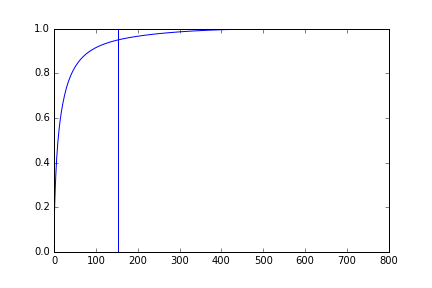

In [288]:
feature_fraction = np.cumsum(TrD)/np.sum(TrD)
threshold = np.argmin(np.abs(feature_fraction-0.95))
print 'include {} features to reach 95% threshold'.format(threshold)
plt.figure()
plt.plot(feature_fraction)
plt.axvline(threshold)

## VISUALISE RECONSTRUCTED IMAGE

<IPython.core.display.Javascript object>


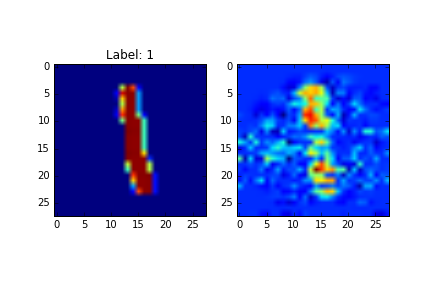

In [298]:
i = 6 #image index
p = threshold #set number of principle components
f, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(TrImgs[i].reshape(28,28)) #original
ax0.set_title('Label: '+str(TrLbls[i])) #original label
r = ReconstImgs(TrImgs[:10],TrU,p) #process 10 images only for speed
ax1.imshow((np.real(r[i]).astype('int')).reshape(28,28))

# Projected Data

## 2 Components

In [307]:
Imgs2Comps = ReconstImgs(TrImgs,TrU,2)

<IPython.core.display.Javascript object>


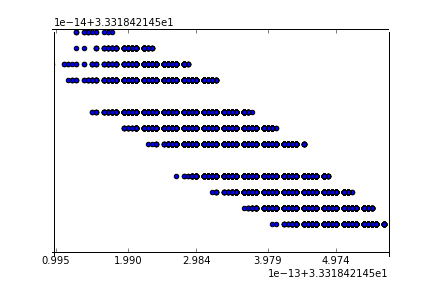

In [312]:
plt.figure()
# plt.autoscale(enable=False)
plt.scatter(Imgs2Comps[:,0],Imgs2Comps[:,1])
plt.xlim(np.min(Imgs2Comps[:,0]),np.max(Imgs2Comps[:,0]))
plt.ylim(np.min(Imgs2Comps[:,1]),np.max(Imgs2Comps[:,1]))
plt.show()

## 3 Components

In [313]:
Imgs3Comps = ReconstImgs(TrImgs,TrU,3)

<IPython.core.display.Javascript object>


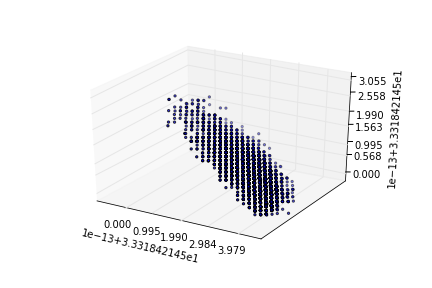

In [342]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Imgs3Comps[:,0][::10],Imgs3Comps[:,1][::10],Imgs3Comps[:,2][::10],marker='.')
ax.set_xlim(np.min(Imgs3Comps[:,0]),np.max(Imgs3Comps[:,0]))
ax.set_ylim(np.min(Imgs3Comps[:,1]),np.max(Imgs3Comps[:,1]))
ax.set_zlim(np.min(Imgs3Comps[:,2]),np.max(Imgs3Comps[:,2]))
plt.show()

## Visualise first 10 eigenvectors

<IPython.core.display.Javascript object>


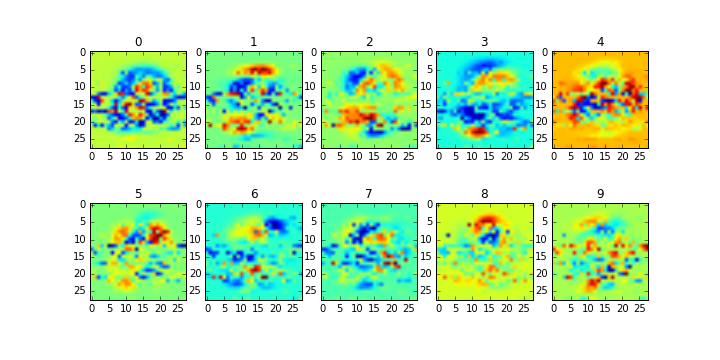

In [341]:
f, axes = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    axes[int(i/5),i%5].imshow((TrU.T[i]).reshape(28,28))
    axes[int(i/5),i%5].set_title(i)